In [11]:
import pdb

import numpy as np
import tensorflow as tf
import IFCC.data.datapipes as dp
import IFCC.data.tepmanip as tepmanip
import matplotlib.pyplot as plt
import pyreadr as pyr
from tensorflow import keras
import importlib
import IFCC.models.encoders as aux
import numpy as np
import time

In [67]:
importlib.reload(tepmanip)
importlib.reload(aux)
importlib.reload(dp)

<module 'IFCC.data.datapipes' from '/home/melbelta/PycharmProjects/IFDC-brnn/IFCC/data/datapipes.py'>

In [17]:
p_ntr='./IFCC/data/tep_source_data/TEP_FaultFree_Training.RData'
p_nval='./IFCC/data/tep_source_data/TEP_FaultFree_Testing.RData'
tep_ntr_Rdata=pyr.read_r(path=p_ntr)
tep_nval_Rdata=pyr.read_r(path=p_nval)

In [18]:
#get and normalize TEP training data
tep_ntr=tepmanip.tep_rdata_to_pd(tep_rdata=tep_ntr_Rdata)
tep_ntr=tepmanip.get_tep_data_fixedsimrun(tep_data=tep_ntr,sim_run=1)
tep_ntr=tepmanip.unify_tepdata_columns_order(tep_ntr)
X_tr,norm_params=tepmanip.normalize_data(data=tep_ntr)

#get TEP validation data
tep_nval=tepmanip.tep_rdata_to_pd(tep_rdata=tep_nval_Rdata)
tep_nval=tepmanip.get_tep_data_fixedsimrun(tep_data=tep_nval,sim_run=1)
tep_nval=tepmanip.unify_tepdata_columns_order(tep_nval)
#split the validation data into testing and validation set and normalize both 
tep_nval,tep_nts=tepmanip.split_tep_data(tep_data=tep_nval,split_frac=.5)
X_val,X_ts=tepmanip.apply_norm(data=[tep_nval,tep_nts],norm_params=norm_params)


X_tr['sample_id']=tep_ntr['sample_id']
X_val['sample_id']=tep_nval['sample_id']
X_ts['sample_id']=tep_nts['sample_id']

# #large dataset
# tep_na=tepmanip.tep_rdata_to_pd(tep_rdata=tep_n_Rdata)
# tep_na=tepmanip.unify_tepdata_columns_order(tep_data=tep_na)
# tep_ntra,other=tepmanip.split_tep_data(tep_data=tep_na,split_frac=0.6) #split the data
# tep_nvala,tep_ntsa=tepmanip.split_tep_data(tep_data=other,split_frac=.5)
# X_tra,norm_paramsa=tepmanip.normalize_data(data=tep_ntra)
# X_vala,X_tsa=tepmanip.apply_norm(data=[tep_nvala,tep_ntsa],norm_params=norm_paramsa)

# X_tra['sample_id']=tep_ntra['sample_id']
# X_vala['sample_id']=tep_nvala['sample_id']
# X_tsa['sample_id']=tep_ntsa['sample_id']


In [43]:
tep_dp=dp.TepDataPipe(input_width=10,label_width=10,shift=1,tr_data= X_tr, val_data= X_val, test_data=X_ts,target_names=None, sampling_rate= 1, batch_size = 64, shuffle_flag  = False, flag_imglike_data=True)
tep_aid_dp=dp.TepDataPipe(input_width=10,label_width=10,shift=1,tr_data= X_tr, val_data= X_val, test_data=X_ts,target_names=None, sampling_rate= 1, seqeunce_stride=10,batch_size = 32, shuffle_flag  = False, flag_imglike_data=True)

#tep_dp.visualize_batch(tep_dp.example[0])

<font size="12"> Conv-LSTM-Conv </font>

In [48]:
red_dim=52# number of variables in the TEP
e_l=[
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-1,1'),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-1,2'),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-1,3'),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-1,4'),
        keras.layers.MaxPool2D(pool_size=(2,2),name='pool-1'),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-2,1'),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-2,2'),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',name='conv-2,3'),
        keras.layers.MaxPool2D(pool_size=(2,2),name='pool-2'),
        keras.layers.Flatten(),
        keras.layers.Dense(red_dim,activation='tanh')]
ce=aux.CustomEncoder(layers=e_l)

cell=aux.CustomLstm(num_time_steps=10,num_hidden_states=red_dim)

d_l=[keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
     keras.layers.Conv2D(64,(4,4),activation='relu',padding='same'),
     keras.layers.Conv2D(32,(5,5),activation='relu',padding='same'),
     keras.layers.Conv2D(1,(2,2),activation='relu',padding='same')]
cd=aux.CustomDecoderLstm(decoder_layers=d_l,custom_lstm=cell)


cae=aux.AutoEncoder(encoder=ce,decoder=cd)



In [68]:
num_epochs=200
h=aux.train_cae(model=cae,loss_fn=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(),metric=keras.metrics.MeanSquaredError(),num_epochs=num_epochs,datapipe=tep_dp)


2023-11-13 13:32:05.581687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [490]
	 [[{{node Placeholder/_8}}]]
2023-11-13 13:32:05.582088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-11-13 13:32:10.845099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [480,52]
	 [[{{node Pla

[<tf.Tensor: shape=(), dtype=float32, numpy=1.1555659>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1555492>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.15

2023-11-13 13:53:47.443843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]
2023-11-13 13:53:47.444238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [49]
	 [[{{node Placeholder/_8}}]]


[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >]

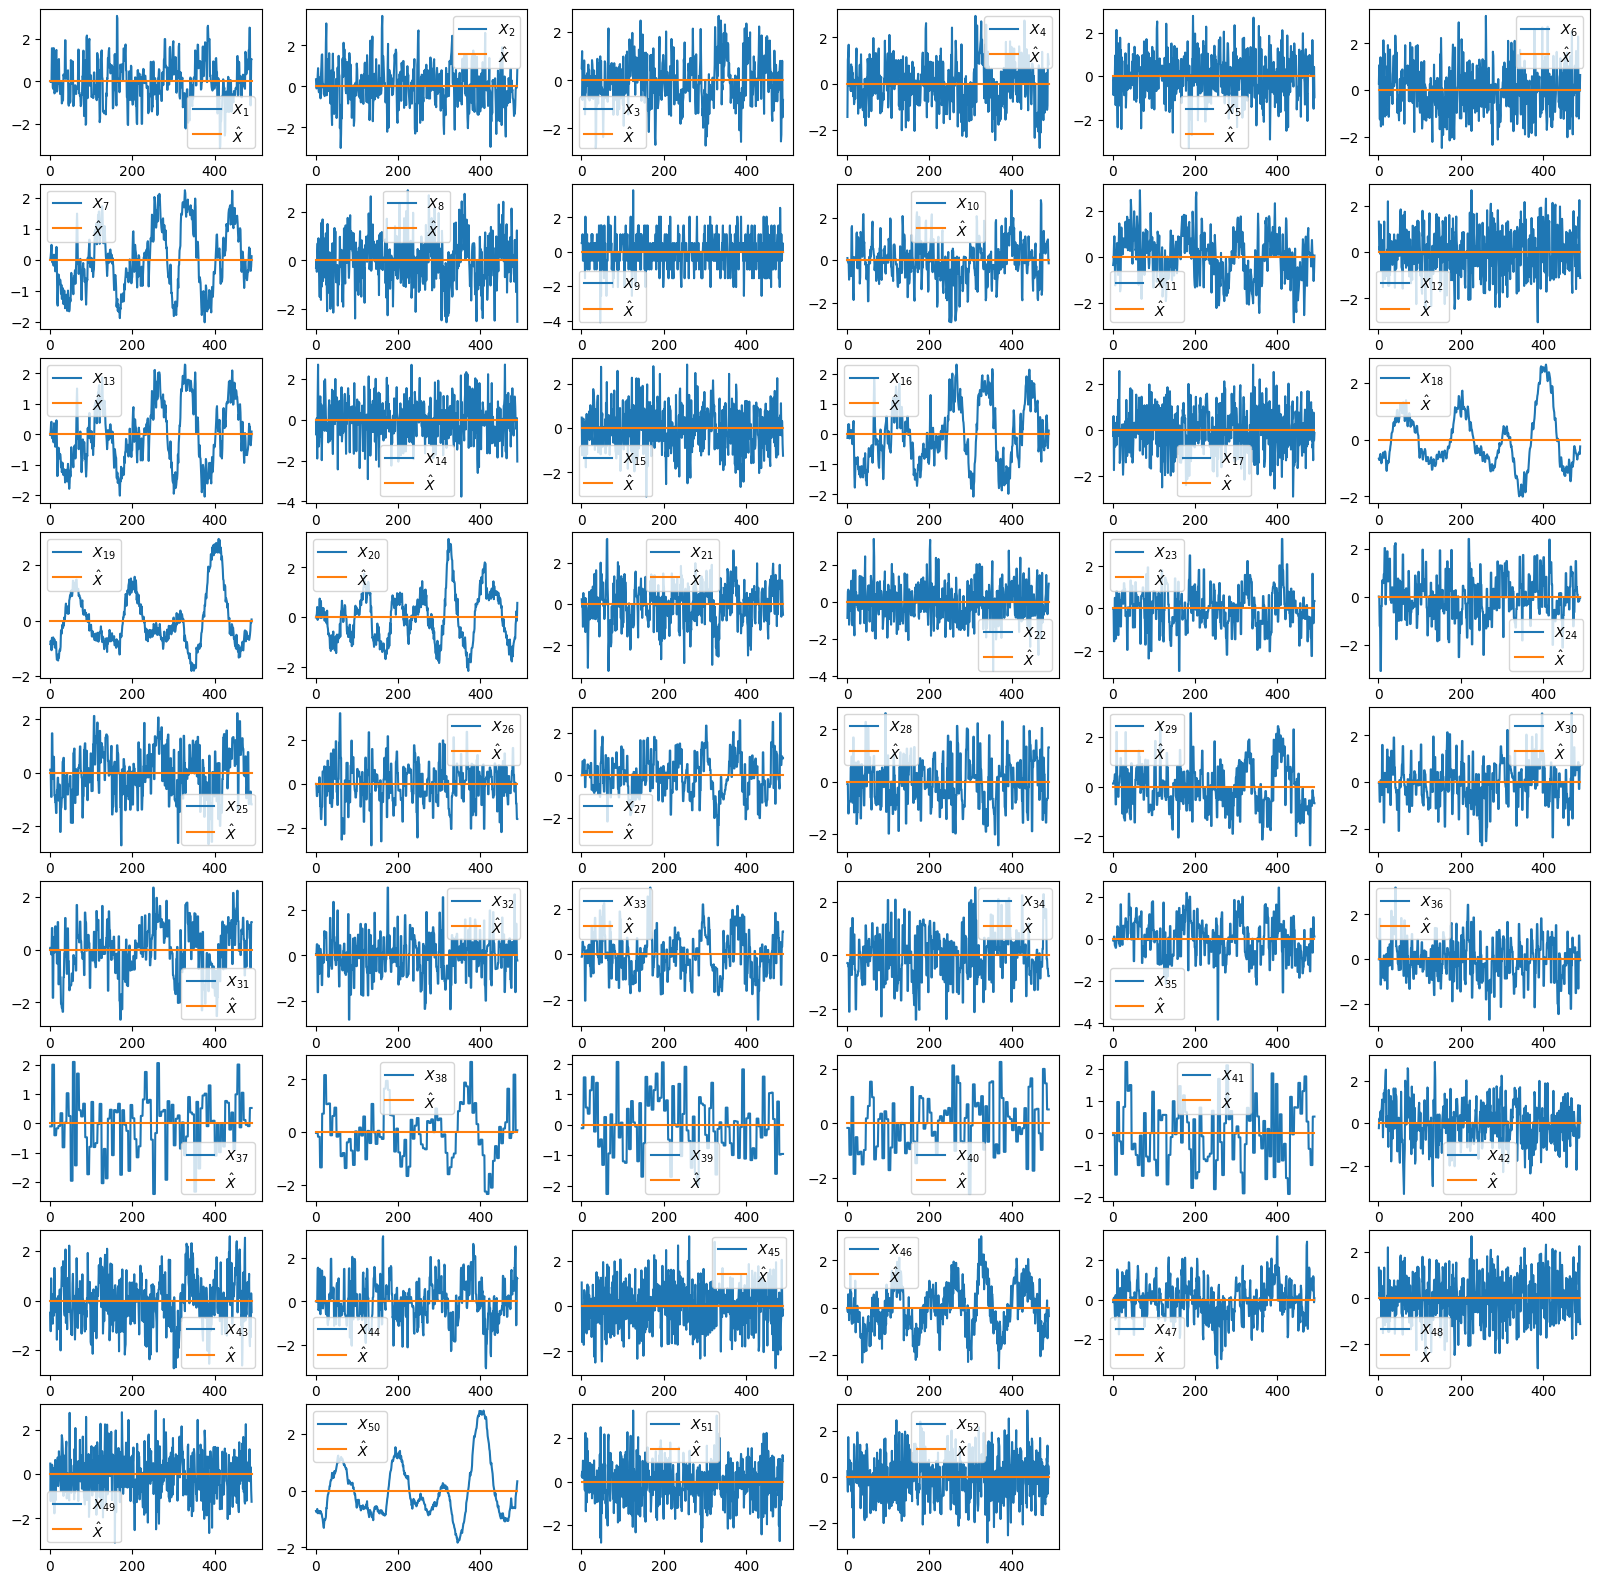

In [69]:
aux.visualize_reconstruction(tep_aid_dp.train_ds,cae)

<font size="12"> Conv-FC-Conv </font>


In [73]:
ex_i,ex_o=tep_dp.example
img_shape=ex_i.shape[1:]

red_dim=52
k_size=(3,3)
act_fun='tanh'
e_l=[keras.layers.UpSampling2D(),
     keras.layers.Conv2D(32,kernel_size=k_size,activation=act_fun),
     keras.layers.Conv2D(64,kernel_size=k_size,activation=act_fun),
     keras.layers.Flatten(),
     keras.layers.Dense(red_dim,activation='relu')]
ce=aux.CustomEncoder(layers=e_l)

decoder_info=ce.get_layers_info(encoder_input_shape=img_shape)
num_dense_units=decoder_info[-2][-1][-1]
decoder_reshape_target=decoder_info[-3][-1]
decoder_info


[[1, 'up_sampling2d', (None, None, None), [20, 104, 1]],
 [2, 'conv2d_28', (32, (3, 3), 'valid'), [18, 102, 32]],
 [3, 'conv2d_29', (64, (3, 3), 'valid'), [16, 100, 64]],
 [4, 'conv2d_30', (128, (3, 3), 'valid'), [14, 98, 128]],
 [5, 'flatten_7', (None, None, None), [175616]],
 [6, 'dense_7', (None, None, None), [52]]]

In [74]:
d_l=[keras.layers.Dense(num_dense_units,activation='relu'),
     keras.layers.Reshape(target_shape=decoder_reshape_target),
     keras.layers.Conv2DTranspose(128,kernel_size=k_size,activation=act_fun),
     keras.layers.Conv2DTranspose(64,kernel_size=k_size,activation=act_fun),
     keras.layers.Conv2DTranspose(32,kernel_size=k_size,activation=act_fun),
     keras.layers.Conv2DTranspose(1,kernel_size=k_size,activation=act_fun,padding='same'),
     keras.layers.MaxPool2D()
     ]
cd=aux.CustomDecoder(decoder_layers=d_l,target_shape=img_shape)
print(img_shape)
cd.get_layers_info(decoder_input_shape=[red_dim])

(10, 52, 1)
Note: These are the layers information before correcting the structure to match the target shape


[[1, 'dense_8', (None, None, None), [175616]],
 [2, 'reshape', (None, None, None), [14, 98, 128]],
 [3, 'conv2d_transpose', (128, (3, 3), 'valid'), [16, 100, 128]],
 [4, 'conv2d_transpose_1', (64, (3, 3), 'valid'), [18, 102, 64]],
 [5, 'conv2d_transpose_2', (32, (3, 3), 'valid'), [20, 104, 32]],
 [6, 'conv2d_transpose_3', (1, (3, 3), 'same'), [20, 104, 1]],
 [7, 'max_pooling2d', (None, None, None), [10, 52, 1]]]

In [75]:
cae=keras.Sequential([ce,cd])
num_epochs=200
h=aux.train_cae(model=cae,loss_fn=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(),metric=keras.metrics.MeanSquaredError(),num_epochs=num_epochs,datapipe=tep_dp)


2023-11-13 13:55:09.493050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [490]
	 [[{{node Placeholder/_8}}]]
2023-11-13 13:55:09.493392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-11-13 13:55:21.859314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [480,52]
	 [[{{node Pla

<tf.Tensor: shape=(), dtype=float32, numpy=0.58250886>

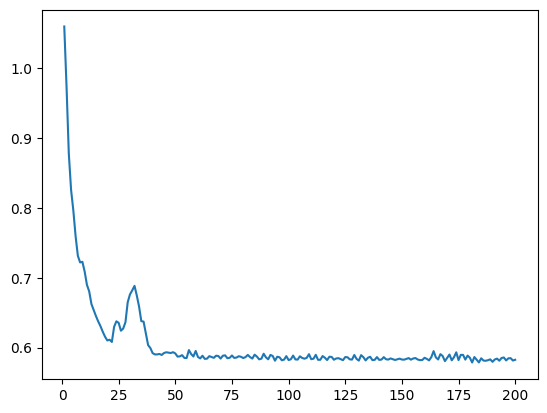

In [76]:

plt.plot(np.arange(1,num_epochs+1),h['val_loss'])
h['val_loss'][-1]

2023-11-13 14:50:25.989676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [49]
	 [[{{node Placeholder/_8}}]]
2023-11-13 14:50:25.989989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]


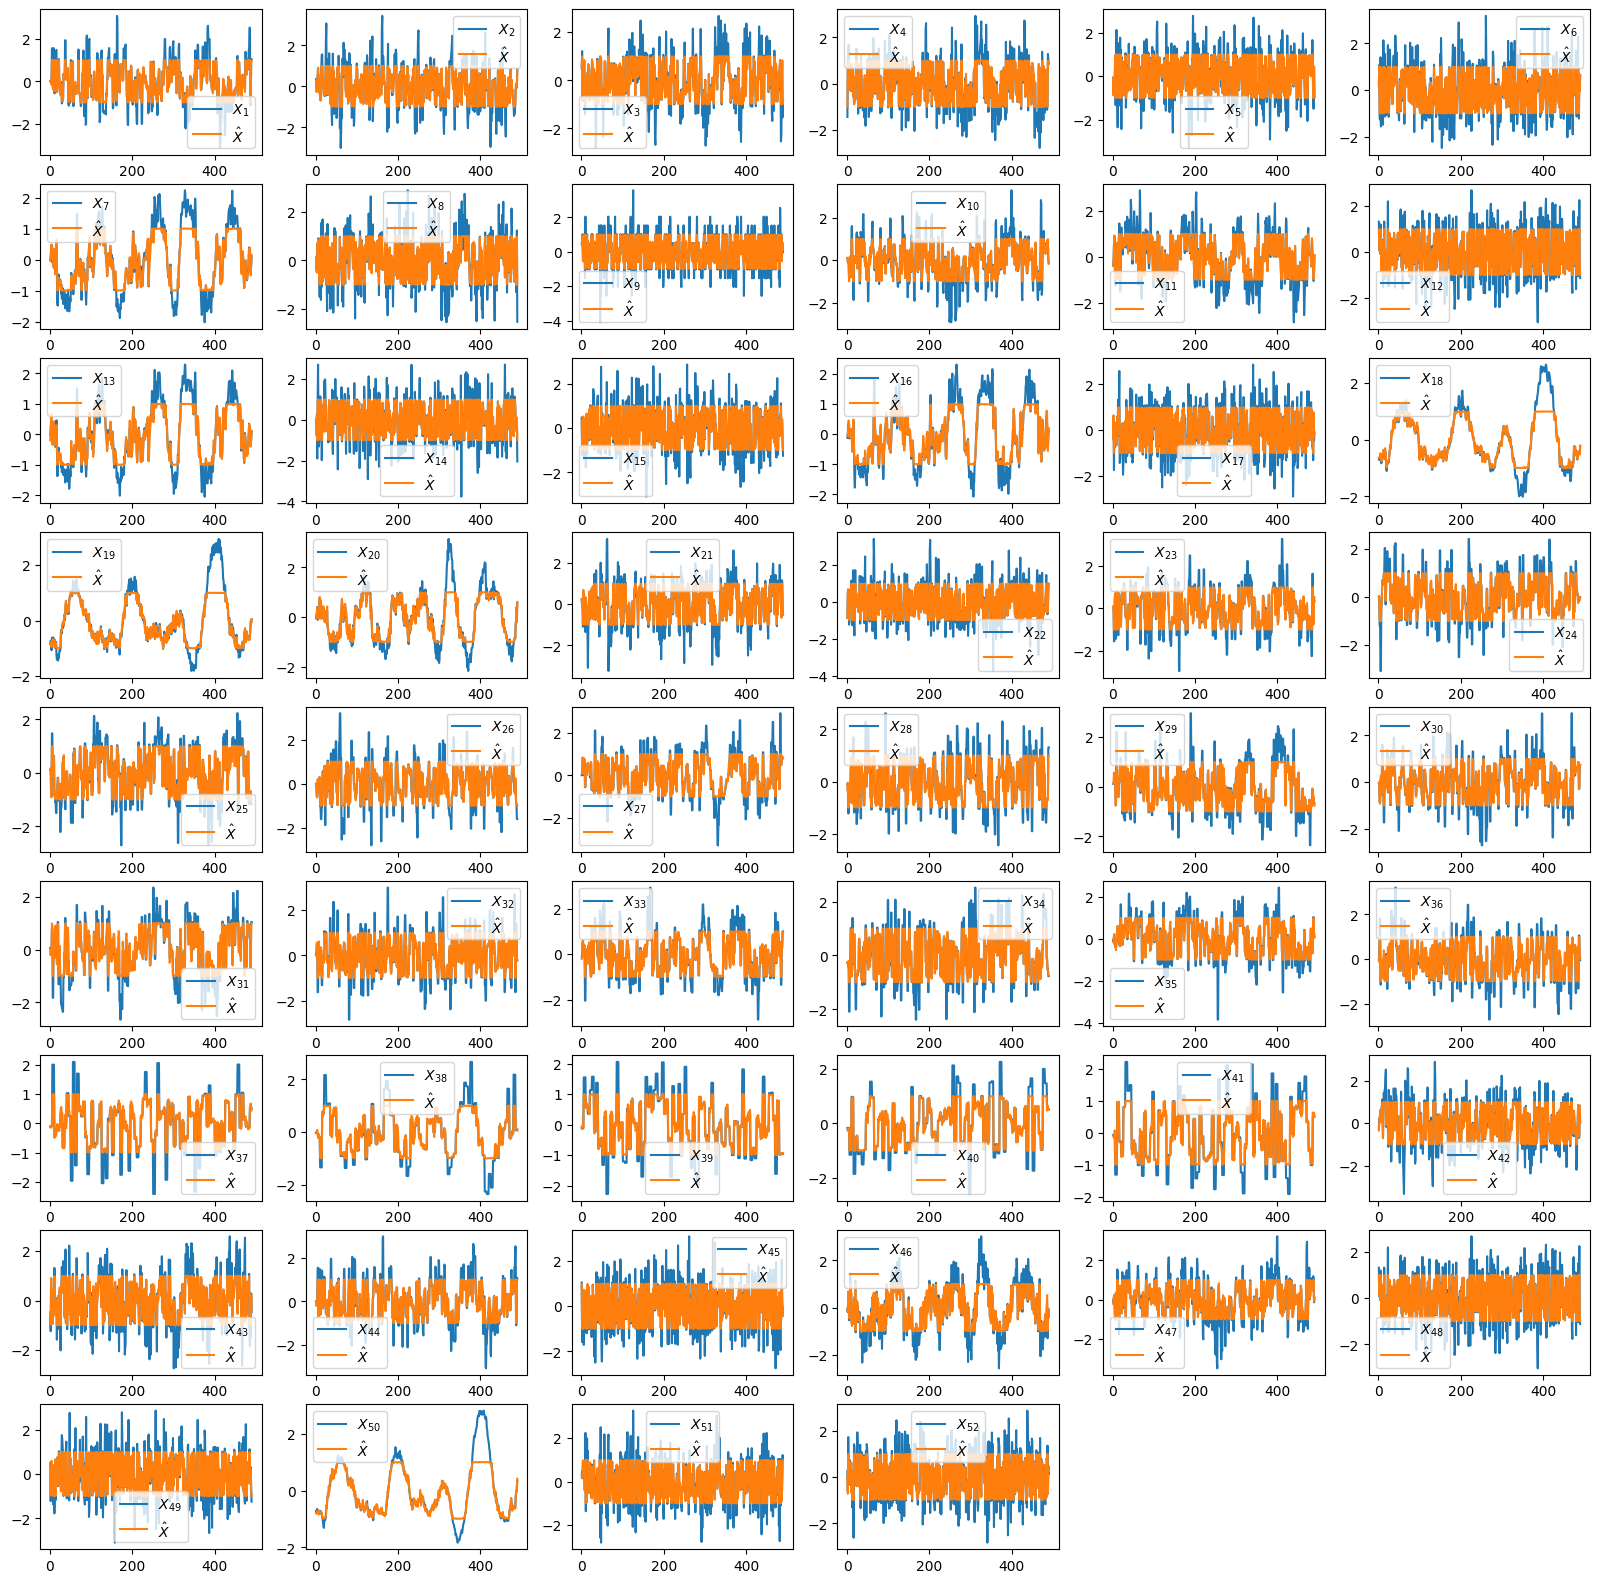

In [77]:
ax=aux.visualize_reconstruction(tep_aid_dp.train_ds,cae)

<font size="12"> Conv-LSTM-Conv </font>


In [77]:
exec_time=[]
x=tep_dp.example
print(x.shape)
for i in range(10):
    t_o=time.time()
    Y=cae(x)
    t_f=time.time()
    exec_time.append(t_f-t_o)

print('The mean exec time is: {}'.format(tf.math.reduce_mean(exec_time)))
print('The std of exec time is: {}'.format(tf.math.reduce_variance(exec_time)))


(64, 10, 52, 1)
The mean exec time is: 0.24600426852703094
The std of exec time is: 0.0022469095420092344


In [78]:

h=aux.train_cae(model=cae,loss_fn=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(),metric=keras.metrics.MeanSquaredError(),num_epochs=200,datapipe=tep_dp)


2023-10-05 13:38:33.547304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-10-05 13:38:33.547860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [316]
	 [[{{node Placeholder/_8}}]]
2023-10-05 13:38:37.290520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [78]
	 [[{{node Placehol

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(1,201),h['val_loss'])
h['val_loss'][-1]

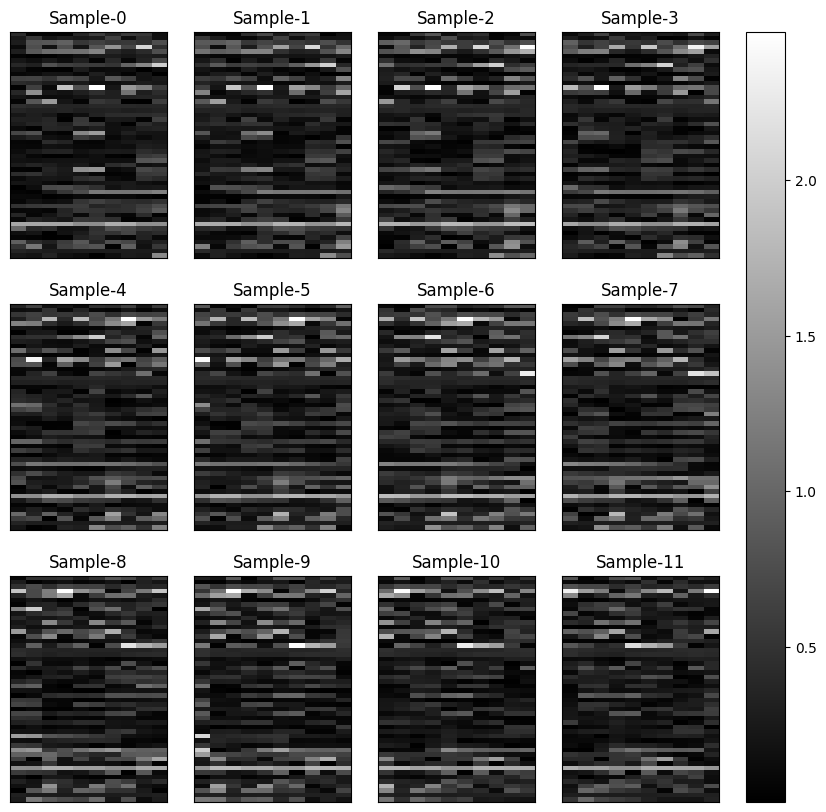

In [53]:
tep_dp.visualize_reconst_error(databatch=tep_dp.example,cae_model=cae)

In [127]:
class conv_block(keras.layers.Layer):

        def __init__(self,kernel_size,num_filters,order:int,activation:str='relu',pooling_size=(2,2),maintain_size_flag:bool=False):
            super().__init__()
            self.kernel_size=kernel_size
            self.num_filters=num_filters
            self.activation=activation
            self.pooling_size=pooling_size
            self.order=order #the order of the block in the architecture convolutional part
            if maintain_size_flag:
                self.padding='same'
                pool_strides=1
            else:
                self.padding='valid'
                pool_strides=None

            self.t_layers=[keras.layers.Conv2D(filters=self.num_filters,kernel_size=self.kernel_size,padding=self.padding,activation=self.activation,name='conv-'+str(self.order)),
                           keras.layers.AvgPool2D(pool_size=self.pooling_size,strides=pool_strides,padding=self.padding,name='pooling-'+str(self.order))]
        def call(self,x):
                for layer in self.t_layers:
                    x=layer(x)

                return x


class  deconv_block(keras.layers.Layer):

    def __init__(self,kernel_size,num_filters,order:int,activation:str='relu',upsampling_size=(2,2),maintain_size_flag:bool=False):
        super().__init__()
        self.kernel_size=kernel_size
        self.num_filters=num_filters
        self.activation=activation
        self.order=order #the order of the block in the architecture convolutional part
        if maintain_size_flag:
            self.padding='same'
            self.upsampling_size=1
        else:
            self.padding='valid'
            self.upsampling_size=upsampling_size

        self.t_layers=[keras.layers.UpSampling2D(size=self.upsampling_size,name='upsampling-'+str(self.order)),
                       keras.layers.Conv2DTranspose(filters=self.num_filters,kernel_size=self.kernel_size,padding=self.padding,activation=self.activation,name='deconv-'+str(self.order))]
    def call(self,x):
        for layer in self.t_layers:
            x=layer(x)

        return x

class Test_Cae(keras.Model):

    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder_mdl=encoder
        self.decoder_mdl=decoder

    def call(self,x):
        return self.decoder_mdl(self.encoder_mdl(x))

In [130]:
red_dim=52
l=[conv_block(kernel_size=4,num_filters=32,order=1,maintain_size_flag=True),
   conv_block(kernel_size=3,num_filters=16,order=2,maintain_size_flag=True),
   conv_block(kernel_size=3,num_filters=8,order=3),
   keras.layers.Flatten(name='flatten'),
   keras.layers.Dense(red_dim,activation='relu',name='FC')
        ]
encoder_mdl=aux.CustomEncoder(layers=l)

dl=[keras.layers.Dense(800,activation='relu',name='FC'),
    keras.layers.Reshape(target_shape=[4,25,8]),
    deconv_block(kernel_size=3,num_filters=16,order=1),
    deconv_block(kernel_size=3,num_filters=32,order=2,maintain_size_flag=True),
    deconv_block(kernel_size=4,num_filters=1,order=3,maintain_size_flag=True)]
decoder_mdl=aux.CustomDecoder(decoder_layers=dl,target_shape=dummy_var.shape[1:])

In [131]:
test_cae=Test_Cae(encoder=encoder_mdl,decoder=decoder_mdl)

In [ ]:
clstm=keras.layers.ConvLSTM2D(filters=32,kernel_size=3,)
d

In [133]:
h=aux.train_cae(model=test_cae,loss_fn=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(),metric=keras.metrics.MeanSquaredError(),num_epochs=200,datapipe=tep_dp)

2023-08-10 12:07:17.514661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [316]
	 [[{{node Placeholder/_8}}]]
2023-08-10 12:07:17.515523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [325,52,1]
	 [[{{node Placeholder/_0}}]]
2023-08-10 12:07:19.092514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [78]

<tf.Tensor: shape=(), dtype=float32, numpy=0.58097816>

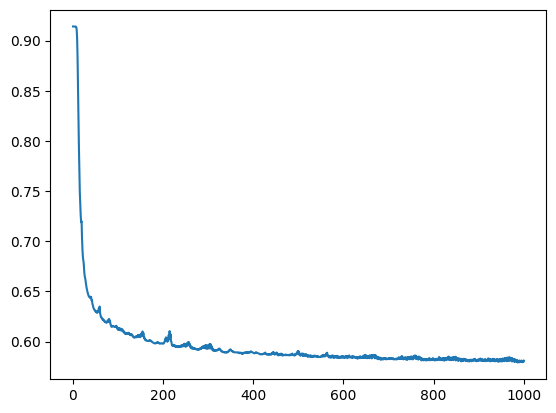

In [134]:
plt.plot(np.arange(1,1001),h['val_loss'])
h['val_loss'][-1]